In [41]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import shap
import os
import sys
import collections
import torch

from scipy import stats
from shapreg import shapley, games, removal, shapley_sampling
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection

from captum.attr import (
    DeepLift,
    FeatureAblation,
    FeaturePermutation,
    IntegratedGradients,
    KernelShap,
    Lime,
    ShapleyValueSampling,
    GradientShap,
)


module_path = os.path.abspath(os.path.join('CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as cate_models_masks
import catenets.models.torch.tlearner as tlearner

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
def plot_feature_values(feature_values):

    ind = np.argpartition(np.abs(feature_values).mean(0).round(2), -15)[-15:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(names[ind], np.abs(feature_values[:, ind]).mean(0).round(2))
    ]

    shap.summary_plot(
        feature_values[:, ind],
        X_test[:, ind], 
        feature_names=feature_names,
        title = "IG"
     )
    
def plot_feature_values_ind(feature_values, indices):
    
    selected_sample = feature_values[indices]
    filtered_test = X_test[indices]
    
    ind = np.argpartition(np.abs(selected_sample).mean(0).round(2), -15)[-15:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(names[ind], np.abs(selected_sample[:, ind]).mean(0).round(2))
    ]

    shap.summary_plot(
        selected_sample[:, ind],
        filtered_test[:, ind], 
        feature_names=feature_names,
        title = "IG"
     )

def normalize_data(X_train):
    
    X_normalized_train = (X_train - np.min(X_train, axis=0)) / (np.max(X_train, axis=0) - np.min(X_train, axis=0))

    return X_normalized_train

In [50]:
#### filtering out procedure

fluid_cohort = pd.read_pickle("data/low_bp_survival.pkl")
#fluid_cohort = pd.read_pickle("data/trauma_team_activated.pkl")
#fluid_cohort = pd.read_pickle("data/trauma_responder.pkl")

#
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='proc')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='ethnicity')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='residencestate')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='toxicologyresults')))]


x = fluid_cohort.loc[:, ~fluid_cohort.columns.isin(["registryid",
                                                            "COV",
                                                            "TT",
                                                            "scenegcsmotor",
                                                            "scenegcseye",
                                                            "scenegcsverbal",
                                                            "edgcsmotor",
                                                            "edgcseye",
                                                            "edgcsverbal",
                                                            "outcome",
                                                            "sex_F",
                                                            "traumatype_P",
                                                            "traumatype_other"
                                                            ])]

### normalize x_train 
#x = x_train.values 

n, feature_size = x.shape
names = x.drop(["treated"], axis=1).columns
treatment_index = x.columns.get_loc("treated")
sex_index = x.columns.get_loc("sex_M")

var_index = [i for i in range(feature_size) if i != treatment_index]

x_norm = normalize_data(x)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_norm)
x_train_scaled = imp.transform(x_norm)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             fluid_cohort["outcome"], 
                                             test_size=0.3, 
                                             random_state=0,
                                             stratify=fluid_cohort["outcome"]
                                    )

w_train = X_train[:, treatment_index]
w_test =  X_test[:, treatment_index]
X_train = X_train[:,var_index]
X_test = X_test[:, var_index]

print(y_train.shape)
device = "cpu"

learner_explanations = {}

#### Getting top 10 features from multiple runs. 

trials = 50
results_train = np.zeros((trials, len(X_train)))
results_test = np.zeros((trials, len(X_test)))


for i in range(trials):
    
    model = tlearner.TLearner(  
                                X_train.shape[1],
                                binary_y=(len(np.unique(y_train)) == 2),
                                n_layers_out=2,
                                n_units_out=50,
                                batch_size=256,
                                n_iter=2000,
                                nonlin="relu",
                                device=device,
                            )

    model.fit(X_train, y_train, w_train)
    
    results_train[i] = model(X_train).detach().cpu().numpy().flatten()
    results_test[i] = model(X_test).detach().cpu().numpy().flatten()

(702,)
binary outcome
binary outcome
[tlearner_po_estimator_0] Epoch: 0, current validation loss: 0.6120942234992981, train_loss: 0.7330746054649353
[tlearner_po_estimator_0] Epoch: 50, current validation loss: 0.5546475052833557, train_loss: 0.6384575366973877
[tlearner_po_estimator_0] Epoch: 100, current validation loss: 0.5109399557113647, train_loss: 0.5634572505950928
[tlearner_po_estimator_0] Epoch: 150, current validation loss: 0.47641149163246155, train_loss: 0.5038979053497314
[tlearner_po_estimator_0] Epoch: 200, current validation loss: 0.45103392004966736, train_loss: 0.453020304441452
[tlearner_po_estimator_0] Epoch: 250, current validation loss: 0.43253621459007263, train_loss: 0.41077619791030884
[tlearner_po_estimator_0] Epoch: 300, current validation loss: 0.41705313324928284, train_loss: 0.3723052144050598
[tlearner_po_estimator_0] Epoch: 350, current validation loss: 0.4056563079357147, train_loss: 0.3382008969783783
[tlearner_po_estimator_0] Epoch: 400, current vali

In [51]:
import pickle 

# results_train = pickle.load(open("result_train_responder.pkl", "rb"))
# results_test = pickle.load(open("result_test_responder.pkl", "rb"))

# results_train = results_train.reshape(50, -1)
# results_test = results_test.reshape(50, -1)

print(np.mean(results_train), np.std(results_train)/np.sqrt(results_train.shape[1]))
print(np.mean(results_test), np.std(results_test)/np.sqrt(results_test.shape[1]))

# with open(r"results/massive_trans/result_train_tlearner.pkl", "wb") as output_file:
    
#     pickle.dump(results_train, output_file)

# with open(r"results/massive_trans/result_test_tlearner.pkl", "wb") as output_file:
    
#     pickle.dump(results_test, output_file)

# print(results_train.shape)

-0.11707417977186689 0.009109688035264183
-0.11550465531292563 0.013062980266742378


average tx effect -0.018998036
average tx effect -0.017215595


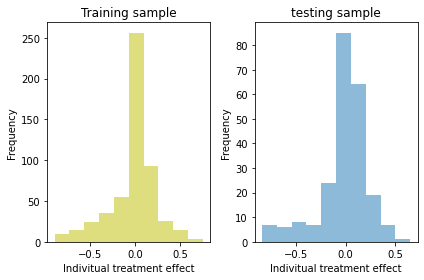

In [16]:
import matplotlib.pyplot as plt 

train_output = model(X_train).detach().cpu().numpy()
test_output = model(X_test).detach().cpu().numpy()

print("average tx effect", np.mean(train_output))
print("average tx effect", np.mean(test_output))

plt.subplot(1,2,1)
plt.hist(train_output, alpha= 0.5, color="y")

plt.title("Training sample")
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(test_output, alpha = 0.5)

plt.title("testing sample")
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")
plt.tight_layout()

In [118]:
sex_index = x.columns.get_loc("sex_M")

male = results_test[:,np.where(X_test[:,sex_index] == 1)[0]]
female = results_test[:, np.where(X_test[:,sex_index] == 0)[0] ]

print(male.shape, female.shape)

print("average tx effect: male", np.mean(male), np.std(male)/np.sqrt(male.shape[1]))
print("average tx effect: female", np.mean(female), np.std(female)/np.sqrt(female.shape[1]))

# plt.subplot(1,2,1)
# plt.hist(male_ate, alpha= 0.5, color="y")

# plt.title("Male - ITE")
# plt.xlabel("Indivitual treatment effect")
# plt.ylabel("Frequency")

# plt.subplot(1,2,2)
# plt.hist(female_ate, alpha = 0.5)

# plt.title("Female - ITE")
# plt.xlabel("Indivitual treatment effect")
# plt.ylabel("Frequency")
# plt.tight_layout()

IndexError: index 2 is out of bounds for axis 1 with size 2

(304, 47)
(50, 1, 222) (50, 1, 82)
average tx effect: male 0.0690913911200829 0.021668366351897606
average tx effect: female 0.06815836914474281 0.033956224425556285


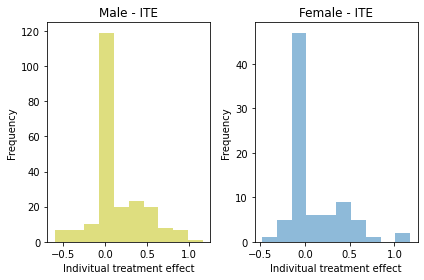

In [45]:
sex_index = x.columns.get_loc("sex_M")

print(X_test.shape)
male = results_test[:, np.where(X_test[:,sex_index] == 1)]
female = results_test[:, np.where(X_test[:,sex_index] == 0) ]

print(male.shape, female.shape)

print("average tx effect: male", np.mean(male), np.std(male)/np.sqrt(male.shape[2]))
print("average tx effect: female", np.mean(female), np.std(female)/np.sqrt(female.shape[2]))

plt.subplot(1,2,1)
plt.hist(male[0, 0, :], alpha= 0.5, color="y")

plt.title("Male - ITE")
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(female[0, 0, :], alpha = 0.5)

plt.title("Female - ITE")
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")
plt.tight_layout()

In [246]:
tx = np.asarray([
    0.08203281,
    0.08250503,
    0.06909127,
    0.014995548,
    0.05894966,
    0.09413,
    0.026347587,
    0.095,

])

print(np.mean(tx), 1.96*np.std(tx)/np.sqrt(tx.shape[0]))

0.065381488125 0.01958733964161962


In [272]:
tx = np.asarray([
0.030421846,
0.02537185,
0.076443054,
0.0158,
0.07017463,
0.04159542,
0.14895725,
 0.15467
])

print(np.mean(tx), 1.96*np.std(tx)/np.sqrt(tx.shape[0]))

0.07042925625 0.035288410487281215


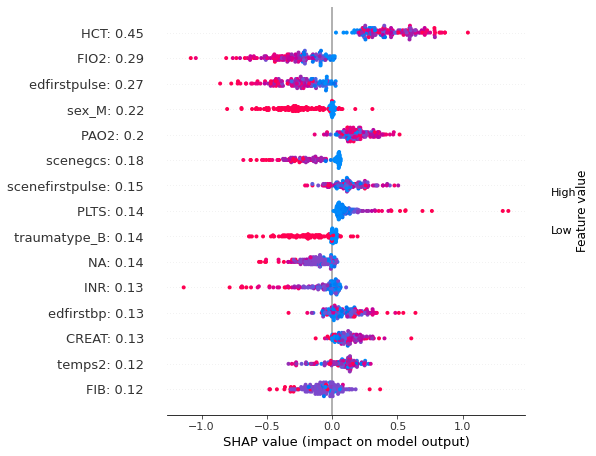

In [411]:
# Shapley value sampling
shapley_value_sampling_model = ShapleyValueSampling(model)


learner_explanations["shapley_sampling_0"] = shapley_value_sampling_model.attribute(
                                                 torch.from_numpy(X_test).to(device).requires_grad_(),
                                                n_samples=500,
                                                perturbations_per_eval=10,
                                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["shapley_sampling_0"])

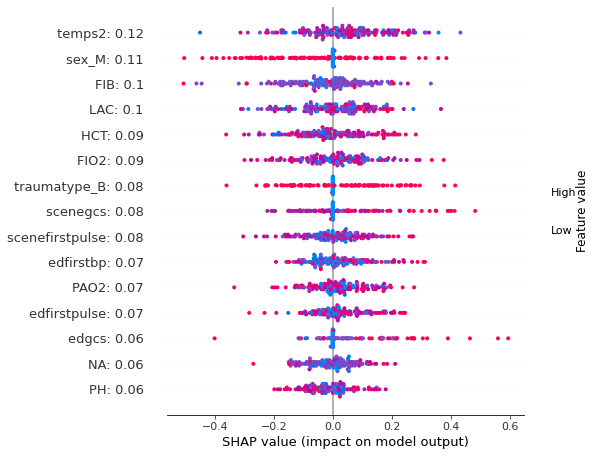

In [410]:
# Shapley value sampling
ig = IntegratedGradients(model)

learner_explanations["ig"] = ig.attribute(
                                    torch.from_numpy(X_test).to(device).requires_grad_(),
                                    n_steps=500,
                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["ig"])

You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.


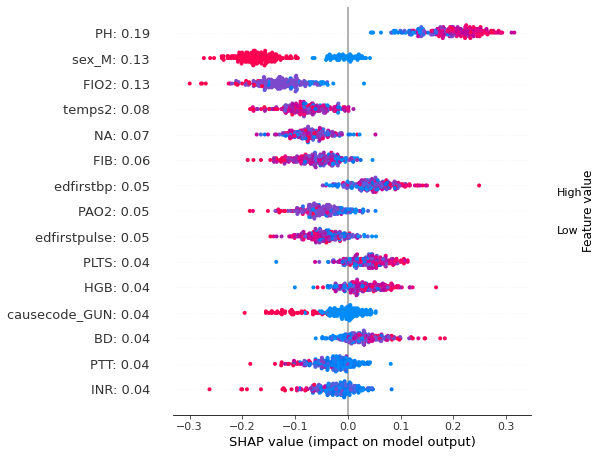

In [11]:
## Kernel shap
kernel_shap_model = KernelShap(model)

learner_explanations["KernelSHAP"] = kernel_shap_model.attribute(
                                             torch.from_numpy(X_test).to(device).requires_grad_(),
                                             n_samples=500,
                                             perturbations_per_eval=10
                                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["KernelSHAP"])

In [21]:
learner_explanations["shapley_sampling"] = np.zeros((X_test.shape))
marginal_extension = removal.MarginalExtension(X_test, model)

for test_ind in range(len(X_test)):
    instance = X_test[test_ind]
    game = games.PredictionGame(marginal_extension, instance)
    explanation = shapley_sampling.ShapleySampling(game, thresh=0.01, batch_size=64)
    learner_explanations["shapley_sampling"][test_ind] = explanation.values.reshape(-1, X_test.shape[1])

plot_feature_values(learner_explanations["shapley_sampling"])

 48%|███████████████████▏                    | 0.4809/1 [00:24<00:26, 51.93s/it]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_29618/835189222.py", line 7, in <cell line: 4>
    explanation = shapley_sampling.ShapleySampling(game, thresh=0.01, batch_size=64)
  File "/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/shapreg/shapley_sampling.py", line 95, in ShapleySampling
    next_value = game(S)
  File "/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/shapreg/games.py", line 122, in __call__
    return self.extension(input_data, S)
  File "/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/shapreg/removal.py", line 102, in __call__
    pred = self.model(x_).detach().cpu().numpy()
  File "/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/torch/nn/modules/module.py", li

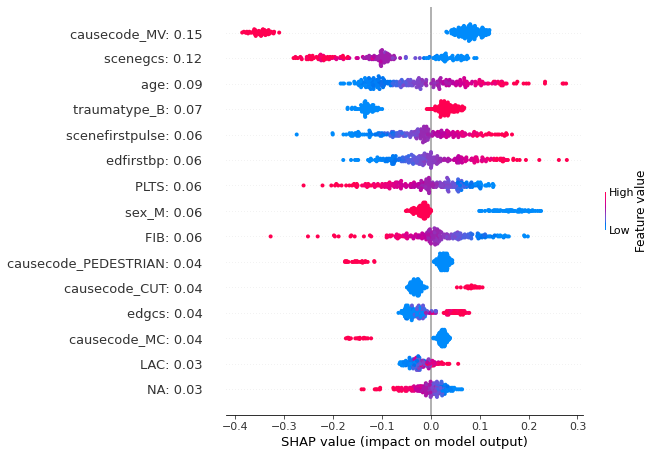

In [8]:
plot_feature_values(learner_explanations["shapley_sampling"])

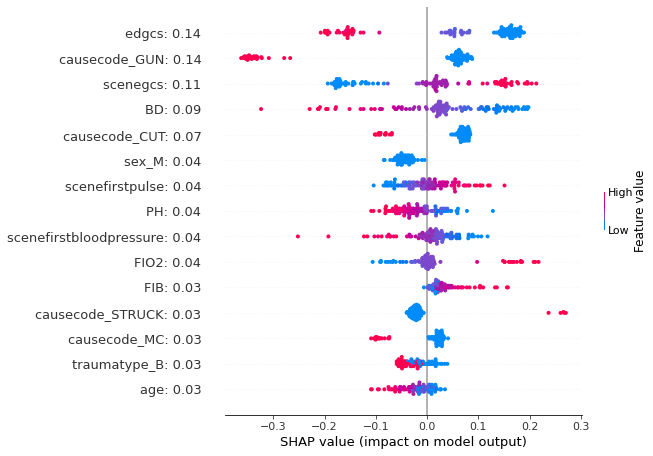

In [121]:
male_indices = np.where(X_test[:,sex_index] == 1)

plot_feature_values_ind(learner_explanations["shapley_sampling"], male_indices)

In [354]:
def calculate_standard_error(feature_values):

    inds = np.argpartition(np.abs(feature_values).mean(0).round(2), -10)[-10:]
    
    print(names[inds])
    std_error = np.zeros(len(inds))
    
    for index, ind in enumerate(inds):
        
        selector = [i for i in range(X_train.shape[1]) if i != ind]
        
        X_train_subset  = X_train[:, selector]
        X_test_subset  = X_test[:, selector]

        subset_model = cate_models_masks.DRLearner(  
                                        X_train_subset.shape[1],
                                        binary_y=(len(np.unique(y_train)) == 2),
                                        n_layers_out=2,
                                        n_units_out=100,
                                        batch_size=256,
                                        n_iter=700,
                                        nonlin="relu",
                                        device=device,
                                        )

        subset_model.fit(X_train_subset, y_train, w_train)
        
        fullset_output =  model(X_test).detach().cpu().numpy()
        subset_output =  subset_model(X_test_subset).detach().cpu().numpy()

        std_error[index] = np.mean((fullset_output - subset_output)**2/np.var(fullset_output))

    return std_error, names[inds]
        
std_error, feature_names = calculate_standard_error(learner_explanations["shapley_sampling"])

Index(['CREAT', 'edgcs', 'causecode_FALL', 'sex_M', 'traumatype_B', 'scenegcs',
       'causecode_CUT', 'PAO2', 'traumatype_P', 'causecode_MV'],
      dtype='object')
[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.740079939365387, train_loss: 0.7228100895881653
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.6624650359153748, train_loss: 0.4955422580242157
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5967710614204407, train_loss: 0.3125419318675995
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.5515241026878357, train_loss: 0.22111071646213531
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.5146235227584839, train_loss: 0.16719689965248108
[po_estimator_0_impute_pos] Epoch: 250, current validation loss: 0.48415467143058777, train_loss: 0.1287057250738144
[po_estimator_0_impute_pos] Epoch: 300, current validation loss: 0.456536203622818, train_loss: 0.11335624754428864
[po_estimator_0_impute

Text(0.5, 1.0, 'Standard Error with Feature Masked out - shapley sampling - 1.84')

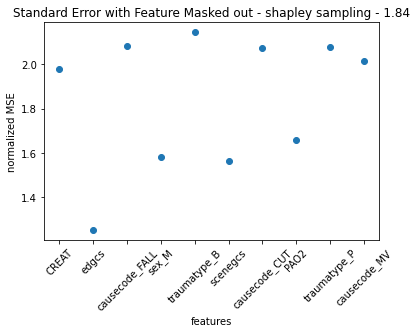

In [355]:

plt.scatter(feature_names , std_error)   
plt.xticks(rotation=45)

plt.ylabel("normalized MSE")
plt.xlabel("features")

plt.title("Standard Error with Feature Masked out - shapley sampling - %s"%(np.round(np.mean(std_error),2)))

In [359]:
sex_index = x.columns.get_loc("sex_M")


(152, 47)
(113, 47) (39, 47)
average tx effect: male 0.4534431
average tx effect: female 0.5026876


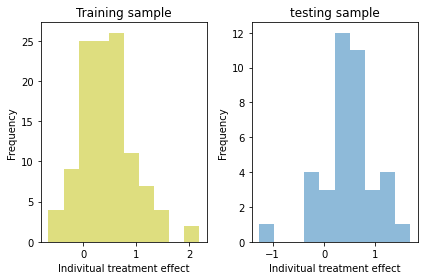

In [44]:
names = x.columns

names  = [i for i in names if i != "treated"]

In [45]:
names

['age',
 'scenegcs',
 'scenefirstbloodpressure',
 'scenefirstpulse',
 'scenefirstrespirationrate',
 'edfirstbp',
 'edfirstpulse',
 'edfirstrespirationrate',
 'temps2',
 'edgcs',
 'causecode_ABUSE',
 'causecode_AIR',
 'causecode_BIKE',
 'causecode_BITES',
 'causecode_CUT',
 'causecode_DROWN',
 'causecode_ENVIRON',
 'causecode_EXPLOSION',
 'causecode_FALL',
 'causecode_GUN',
 'causecode_MACHINE',
 'causecode_MC',
 'causecode_MV',
 'causecode_OTHER',
 'causecode_PEDESTRIAN',
 'causecode_RAILWAY',
 'causecode_STRUCK',
 'causecode_TRANSPORT',
 'sex_M',
 'traumatype_B',
 'traumatype_OTHER',
 'BD',
 'CFSS',
 'COHB',
 'CREAT',
 'FIB',
 'FIO2',
 'HCT',
 'HGB',
 'INR',
 'LAC',
 'NA',
 'PAO2',
 'PH',
 'PLTS',
 'PTT']